# Memory Usage Visualization

In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
from benchmark.environment import IMPROVEMENTS, STATES
from os import chdir
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


if not "PROJECT_DIR" in globals():
    PROJECT_DIR = Path().resolve().parent
    chdir(PROJECT_DIR)


if not "DATA_DIR" in globals():
    DATA_DIR = PROJECT_DIR / "memory-usage" / "data"


if not "FIG_DIR" in globals():
    FIG_DIR = PROJECT_DIR / "memory-usage" / "figures"
    FIG_DIR.mkdir(exist_ok=True, parents=True)

In [12]:
memory_usage = []

for improvement in IMPROVEMENTS:
    for state in STATES:
        df = pd.read_csv(DATA_DIR / f"{improvement}-{state}.csv")
        df["improvement"] = improvement.replace("-", " ").title()
        df["state"] = state.replace("-", " ").title()
        memory_usage.append(df)

memory_usage = pd.concat(memory_usage)
memory_usage.columns = memory_usage.columns.str.replace("-", " ").str.title()
memory_usage["Memory Usage"] = memory_usage["Memory Usage"] / 1024 / 1024
memory_usage["Service"] = (
    memory_usage["Service"]
    .str.replace("dbrepo-", "")
    .str.replace("-", " ")
    .str.replace("db", "database")
    .str.replace("authentication", "auth")
    .str.title()
    .replace("Ui", "UI Service")
)

## Overall Memory Usage

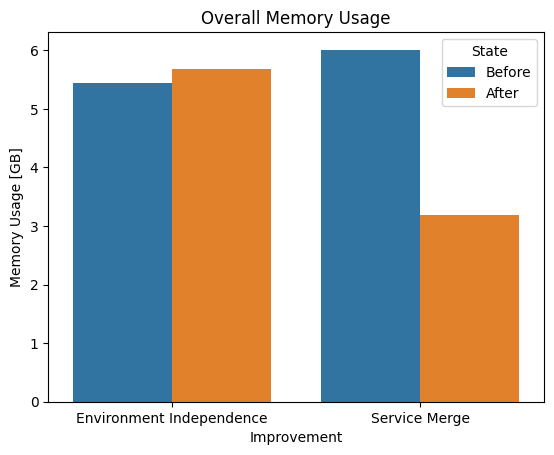

In [13]:
memory_usage_gb = memory_usage.copy()
memory_usage_gb["Memory Usage"] = memory_usage_gb["Memory Usage"] / 1024
sns.barplot(
    data=memory_usage_gb[memory_usage_gb["Databases"] == 0]
    .groupby(["Improvement", "State"])
    .sum()
    .reset_index()
    .sort_values(["Improvement", "State"], ascending=[True, False]),
    x="Improvement",
    y="Memory Usage",
    hue="State",
)
plt.title(f"Overall Memory Usage")
plt.ylabel("Memory Usage [GB]")
plt.savefig(FIG_DIR / "overall-memory-usage.pdf")
plt.show()

## Memory Usage per Service

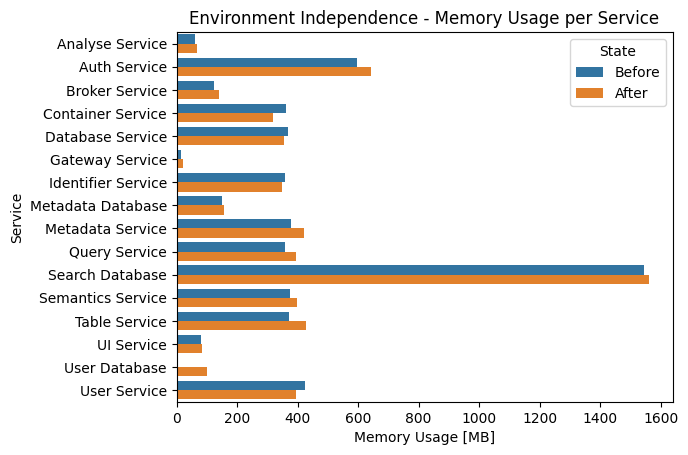

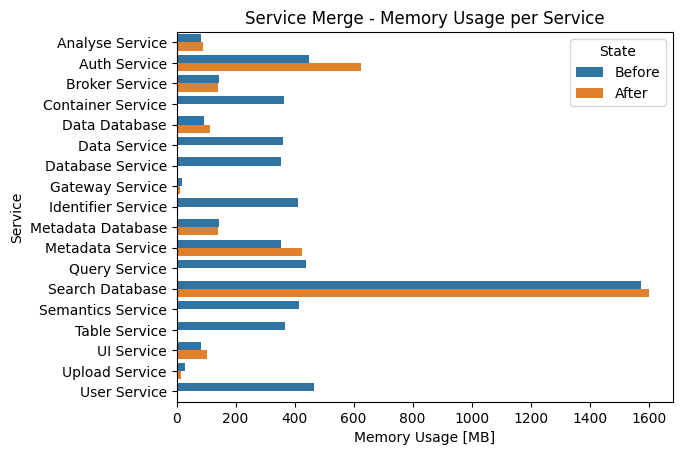

In [14]:
for improvement in IMPROVEMENTS:
    sns.barplot(
        data=memory_usage[
            (memory_usage["Databases"] == 0)
            & (memory_usage["Improvement"] == improvement.replace("-", " ").title())
        ].sort_values(["Service", "State"], ascending=[True, False]),
        x="Memory Usage",
        y="Service",
        hue="State",
    )
    plt.title(f"{improvement.replace('-', ' ').title()} - Memory Usage per Service")
    plt.xlabel("Memory Usage [MB]")
    plt.savefig(FIG_DIR / f"service-memory-usage-{improvement}.pdf")
    plt.show()

## Overall Memory Usage Increase per Database

In [15]:
overall_db_memory_usage = (
    memory_usage.drop(columns="Service")
    .groupby(["Improvement", "State", "Databases"])
    .sum()
    .reset_index()
    .sort_values(["Improvement", "State", "Databases"], ascending=[True, False, True])
)
overall_db_memory_usage["Memory Usage"] = overall_db_memory_usage.groupby(
    ["Improvement", "State"]
)["Memory Usage"].diff()
overall_db_memory_usage = overall_db_memory_usage.dropna().drop(columns="Databases")

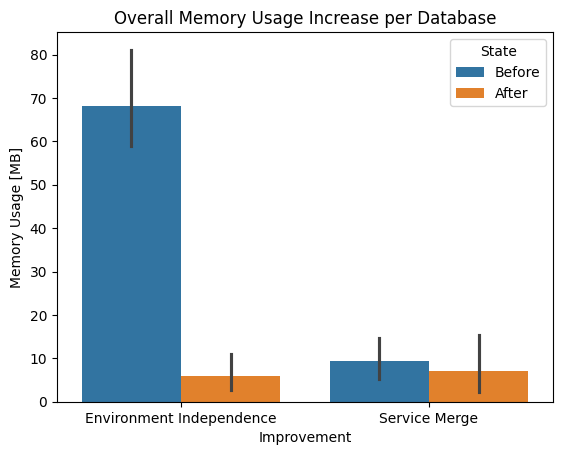

In [16]:
sns.barplot(
    data=overall_db_memory_usage,
    x="Improvement",
    y="Memory Usage",
    hue="State",
)
plt.title(f"Overall Memory Usage Increase per Database")
plt.ylabel("Memory Usage [MB]")
plt.savefig(FIG_DIR / "overall-database-memory-usage.pdf")
plt.show()

## User Database Memory Usage Increase per Database

In [17]:
db_memory_usage = memory_usage[
    memory_usage["Service"].str.contains("^(user|data) ?database", case=False)
]
db_memory_usage = db_memory_usage.sort_values(
    ["Improvement", "State", "Databases"], ascending=[True, False, True]
)
before_env_indep = (db_memory_usage["Improvement"] == "Environment Independence") & (
    db_memory_usage["State"] == "Before"
)
db_memory_usage.loc[~before_env_indep, "Memory Usage"] = (
    db_memory_usage[~before_env_indep]
    .groupby(["Improvement", "State"])["Memory Usage"]
    .diff()
)
db_memory_usage = db_memory_usage[
    (
        db_memory_usage["Service"].str.split(" ").str[-1]
        == db_memory_usage["Databases"].astype(str)
    )
    | ~before_env_indep
]
db_memory_usage = db_memory_usage.dropna().drop(columns="Databases")

/tmp/ipykernel_7187/1642290399.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  memory_usage["Service"].str.contains("^(user|data) ?database", case=False)


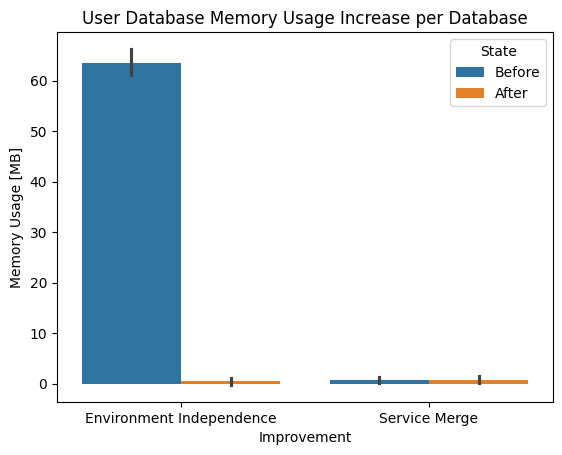

In [18]:
sns.barplot(
    data=db_memory_usage,
    x="Improvement",
    y="Memory Usage",
    hue="State",
)
plt.title(f"User Database Memory Usage Increase per Database")
plt.ylabel("Memory Usage [MB]")
plt.savefig(FIG_DIR / "database-memory-usage.pdf")
plt.show()